In [1]:
# ==============================
# 0. IMPORT & CÀI ĐẶT
# ==============================
!pip install pandas scikit-learn imbalanced-learn xgboost lightgbm catboost -q

import pandas as pd
import numpy as np
import os
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

print("P300: GIẢM S5 = S6 → CHIA TRAIN/TEST → SO SÁNH MÔ HÌNH")
print(f"Thời gian: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


P300: GIẢM S5 = S6 → CHIA TRAIN/TEST → SO SÁNH MÔ HÌNH
Thời gian: 2025-11-17 09:41:18



In [2]:
# ==============================
# 1. THIẾT LẬP THƯ MỤC
# ==============================
BASE_DIR = "eeg_p300_s5_equal_s6"
MODEL_DIR = os.path.join(BASE_DIR, "models")
CM_DIR = os.path.join(BASE_DIR, "confusion_matrices")
RESULT_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CM_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [3]:
# ==============================
# 2. ĐỌC + LỌC S5 & S6
# ==============================
df = pd.read_csv('eeg_features.csv')
df = df[df['label'].isin(['S  5', 'S  6'])].copy()
df['y'] = df['label'].map({'S  5': 0, 'S  6': 1})

X_raw = df[[f'f{i}' for i in range(1778)]].values
y = df['y'].values

# Loại bỏ cột 0 + trùng
zero_cols = np.where(np.all(X_raw == 0, axis=0))[0]
unique_cols = []
seen = set()
for i in range(X_raw.shape[1]):
    col_hash = tuple(X_raw[:, i])
    if col_hash not in seen and i not in zero_cols:
        seen.add(col_hash)
        unique_cols.append(i)
X_clean = X_raw[:, unique_cols]

In [4]:
# ==============================
# 3. GIẢM S5 = S6
# ==============================
n_s6 = sum(y == 1)
n_s5 = sum(y == 0)
print(f"Tổng: S5={n_s5}, S6={n_s6}")

# Giữ toàn bộ S6
idx_s6 = np.where(y == 1)[0]

# Giữ ngẫu nhiên n_s6 mẫu S5
idx_s5 = np.where(y == 0)[0]
np.random.seed(42)
idx_s5_keep = np.random.choice(idx_s5, size=n_s6, replace=False)

# Gộp lại
idx_keep = np.concatenate([idx_s5_keep, idx_s6])
X_balanced = X_clean[idx_keep]
y_balanced = y[idx_keep]

print(f"Sau giảm: S5={sum(y_balanced==0)}, S6={sum(y_balanced==1)} → 1:1")

Tổng: S5=8964, S6=1458
Sau giảm: S5=1458, S6=1458 → 1:1


In [5]:
# ==============================
# 4. CHIA 80/20
# ==============================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

print(f"Train: {len(X_train_raw)} mẫu | Test: {len(X_test_raw)} mẫu")
print(f"Test: S5={sum(y_test==0)}, S6={sum(y_test==1)}")

Train: 2332 mẫu | Test: 584 mẫu
Test: S5=292, S6=292


In [ ]:
# ==============================
# 5. DANH SÁCH MÔ HÌNH
# ==============================
models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, random_seed=42, verbose=False),
    'LogisticReg': LogisticRegressioAn(max_iter=1000, random_state=42, n_jobs=-1)
}

In [7]:

# ==============================
# 6. TRAIN + ĐÁNH GIÁ
# ==============================
results = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

for model_name, model in models.items():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(MODEL_DIR, f"{model_name}_S5eqS6_{timestamp}.pkl")
    cm_path = os.path.join(CM_DIR, f"CM_{model_name}_{timestamp}.png")
    
    print(f"\n→ Huấn luyện {model_name}...", end=" ")
    
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['S5', 'S6'], yticklabels=['S5', 'S6'])
        plt.title(f'{model_name} - S5 = S6')
        plt.ylabel('Thực tế'); plt.xlabel('Dự đoán')
        plt.tight_layout()
        plt.savefig(cm_path, dpi=200)
        plt.close()
        
        # Lưu mô hình + scaler
        joblib.dump(model, model_path)
        joblib.dump(scaler, model_path.replace(".pkl", "_scaler.pkl"))
        
        # Ghi kết quả
        entry = {
            'model': model_name,
            'recall_s6': round(recall, 4),
            'precision_s6': round(precision, 4),
            'f1': round(f1, 4),
            'accuracy': round(acc, 4),
            'model_path': model_path,
            'cm_path': cm_path
        }
        results.append(entry)
        
        print(f"Recall={recall:.4f} | F1={f1:.4f} | Acc={acc:.4f}")
        
    except Exception as e:
        print(f"LỖI: {e}")
        continue


→ Huấn luyện RandomForest... Recall=0.7329 | F1=0.7242 | Acc=0.7209

→ Huấn luyện XGBoost... Recall=0.7432 | F1=0.7444 | Acc=0.7449

→ Huấn luyện LightGBM... Recall=0.6952 | F1=0.7160 | Acc=0.7243

→ Huấn luyện CatBoost... Recall=0.7534 | F1=0.7358 | Acc=0.7295

→ Huấn luyện LogisticReg... Recall=0.6473 | F1=0.6632 | Acc=0.6712


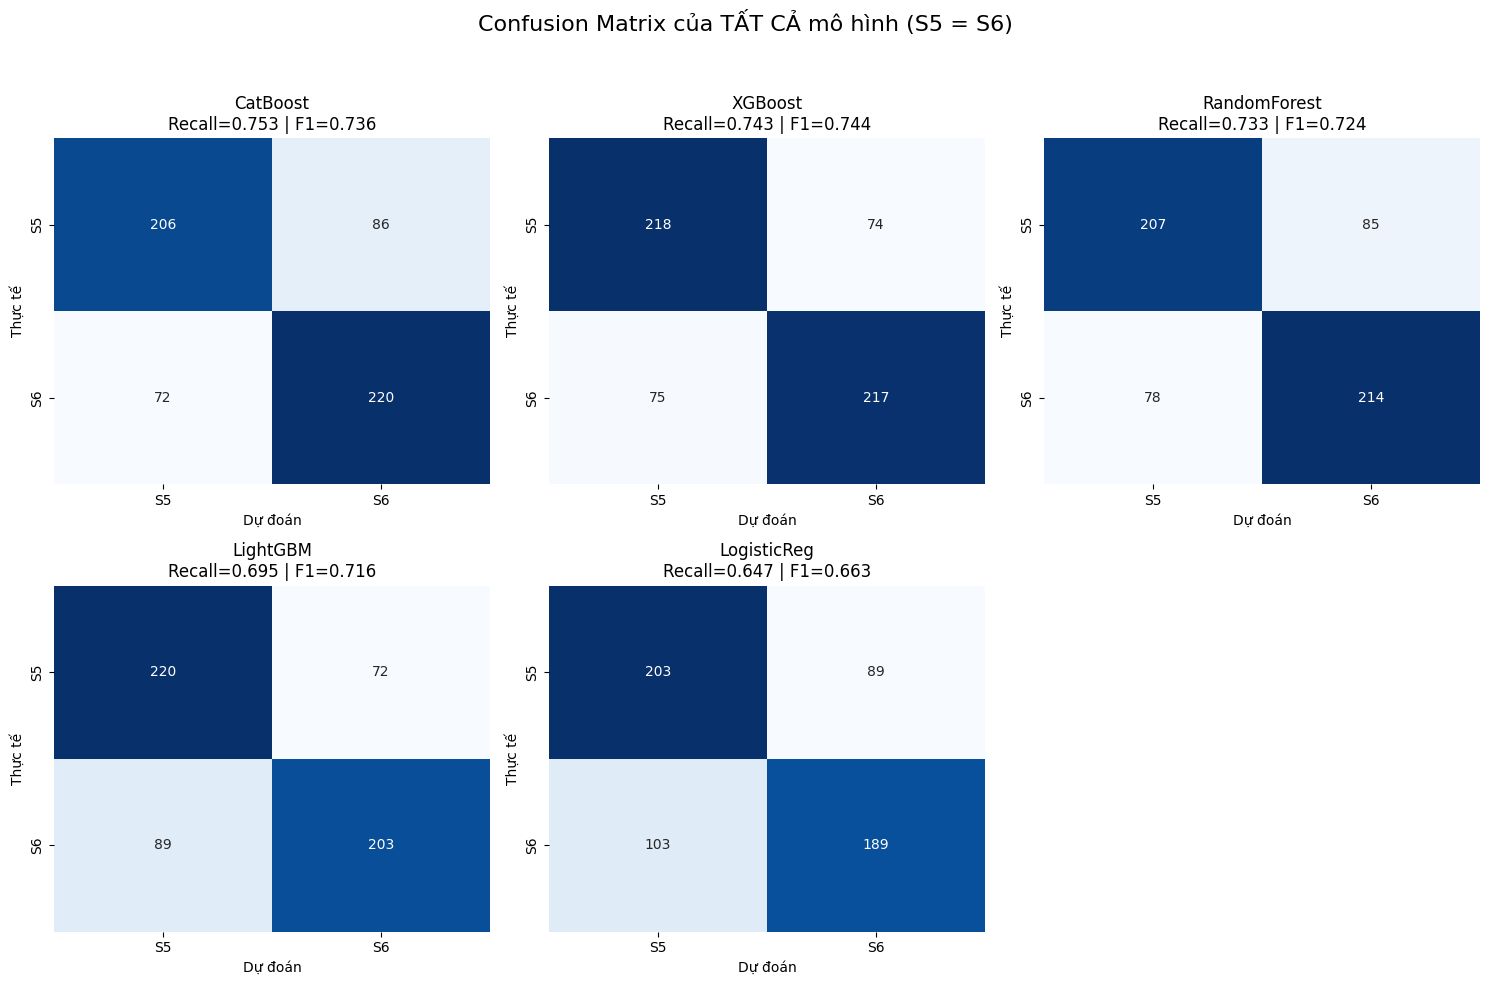

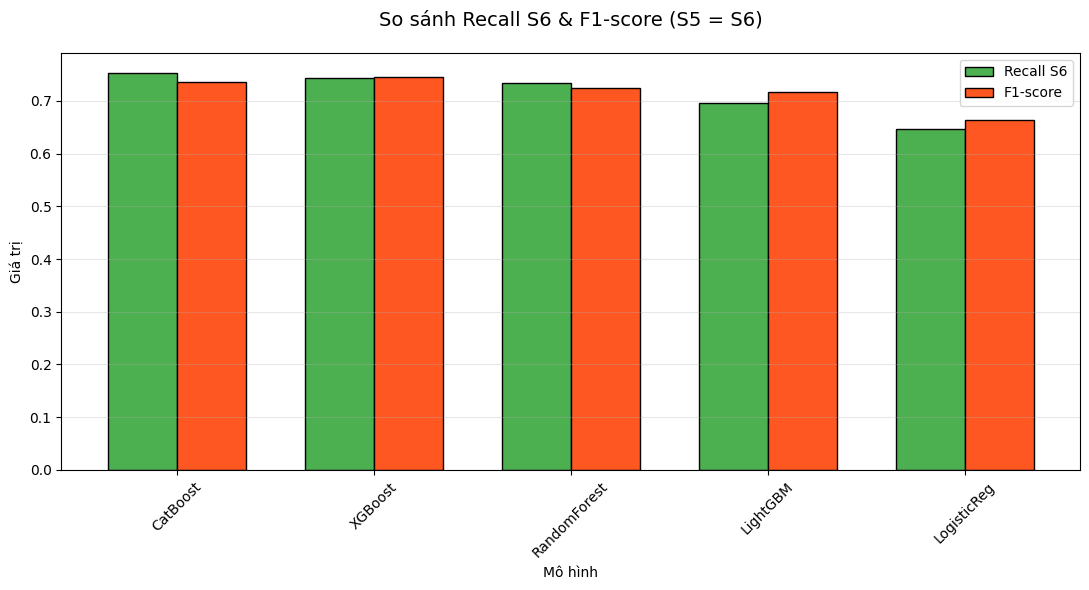


TẤT CẢ MÔ HÌNH ĐÃ LƯU + SO SÁNH (S5 = S6)
       model  recall_s6     f1  precision_s6  accuracy
    CatBoost     0.7534 0.7358        0.7190    0.7295
     XGBoost     0.7432 0.7444        0.7457    0.7449
RandomForest     0.7329 0.7242        0.7157    0.7209
    LightGBM     0.6952 0.7160        0.7382    0.7243
 LogisticReg     0.6473 0.6632        0.6799    0.6712

MÔ HÌNH TỐT NHẤT (Recall cao nhất): CatBoost
→ Recall S6 = 0.7534 | F1 = 0.7358
→ Mô hình: eeg_p300_s5_equal_s6\models\CatBoost_S5eqS6_20251117_094218.pkl
→ Confusion Matrix riêng: eeg_p300_s5_equal_s6\confusion_matrices\CM_CatBoost_20251117_094218.png
→ Tất cả CM trong 1 ảnh: eeg_p300_s5_equal_s6\results\ALL_CONFUSION_MATRICES_20251117_0943.png
→ Biểu đồ so sánh: eeg_p300_s5_equal_s6\results\comparison_chart_20251117_0943.png
→ CSV tất cả mô hình: eeg_p300_s5_equal_s6\results\all_models_s5eqs6_20251117_0943.csv


In [8]:
# ==============================
# 7. LƯU MÔ HÌNH + VẼ CM + SO SÁNH
# ==============================
if results:
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(['recall_s6', 'f1'], ascending=False).reset_index(drop=True)
    
    best = df_results.iloc[0]
    
    # Lưu kết quả
    csv_path = os.path.join(RESULT_DIR, f"all_models_s5eqs6_{datetime.now().strftime('%Y%m%d_%H%M')}.csv")
    df_results.to_csv(csv_path, index=False)

    # ==============================
    # VẼ TẤT CẢ CONFUSION MATRIX TRONG 1 HÌNH
    # ==============================
    n_models = len(df_results)
    cols = 3
    rows = (n_models + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    for idx, row in enumerate(df_results.itertuples()):
        # Load lại để vẽ CM chính xác
        model = joblib.load(row.model_path)
        scaler = joblib.load(row.model_path.replace(".pkl", "_scaler.pkl"))
        X_test_scaled = scaler.transform(X_test_raw)
        y_pred = model.predict(X_test_scaled)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['S5', 'S6'], yticklabels=['S5', 'S6'],
                    ax=axes[idx], cbar=False)
        axes[idx].set_title(f"{row.model}\nRecall={row.recall_s6:.3f} | F1={row.f1:.3f}")
        axes[idx].set_ylabel('Thực tế')
        axes[idx].set_xlabel('Dự đoán')

    for j in range(idx + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Confusion Matrix của TẤT CẢ mô hình (S5 = S6)', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    all_cm_path = os.path.join(RESULT_DIR, f"ALL_CONFUSION_MATRICES_{datetime.now().strftime('%Y%m%d_%H%M')}.png")
    plt.savefig(all_cm_path, dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================
    # VẼ BIỂU ĐỒ SO SÁNH RECALL & F1
    # ==============================
    plt.figure(figsize=(11, 6))
    x = np.arange(len(df_results))
    width = 0.35

    plt.bar(x - width/2, df_results['recall_s6'], width, label='Recall S6', color='#4CAF50', edgecolor='black')
    plt.bar(x + width/2, df_results['f1'], width, label='F1-score', color='#FF5722', edgecolor='black')

    plt.title('So sánh Recall S6 & F1-score (S5 = S6)', fontsize=14, pad=20)
    plt.xlabel('Mô hình')
    plt.ylabel('Giá trị')
    plt.xticks(x, df_results['model'], rotation=45)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()

    chart_path = os.path.join(RESULT_DIR, f"comparison_chart_{datetime.now().strftime('%Y%m%d_%H%M')}.png")
    plt.savefig(chart_path, dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================
    # IN KẾT QUẢ + CHỌN MÔ HÌNH TỐT NHẤT
    # ==============================
    print("\n" + "="*100)
    print("TẤT CẢ MÔ HÌNH ĐÃ LƯU + SO SÁNH (S5 = S6)")
    print("="*100)
    print(df_results[['model', 'recall_s6', 'f1', 'precision_s6', 'accuracy']].to_string(index=False))
    
    print(f"\nMÔ HÌNH TỐT NHẤT (Recall cao nhất): {best['model']}")
    print(f"→ Recall S6 = {best['recall_s6']:.4f} | F1 = {best['f1']:.4f}")
    print(f"→ Mô hình: {best['model_path']}")
    print(f"→ Confusion Matrix riêng: {best['cm_path']}")
    print(f"→ Tất cả CM trong 1 ảnh: {all_cm_path}")
    print(f"→ Biểu đồ so sánh: {chart_path}")
    print(f"→ CSV tất cả mô hình: {csv_path}")

else:
    print("Không có kết quả.")